# GitHub Issues classification

This is a project to classify the **Rails project GitHub issues** into different categories using machine learning techniques. The project aims to analyze the issues reported on the Rails repository and classify them into different labels based on their descriptions. The classification model will help in organizing and prioritizing the issues reported by the community, making it easier for the maintainers to address them efficiently.

## Data Collection

1. **Access GitHub API**: Using the GitHub API to fetch data related to the Rails project issues.
2. **Retrieve Issues Data**: Fetching the last 500 issues from the Rails repository, including closed and open issues.
3. **Data Fields**: The issues data will contain various fields such as `title`, `body`, `labels`, `state`, etc.

In [ ]:
import requests

GITHUB_API_URL = 'https://api.github.com/repos/rails/rails/issues'
PER_PAGE = 100
TOTAL_ISSUES = 500


def fetch_issues(page):
    params = {
        'state': 'all',
        'per_page': PER_PAGE,
        'page': page
    }
    response = requests.get(GITHUB_API_URL, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f'Failed to fetch data: {response.status_code} - {response.text}')


def main():
    all_issues = []
    for page in range(1, (TOTAL_ISSUES // PER_PAGE) + 2):
        issues = fetch_issues(page)
        all_issues.extend(issues)
        if len(issues) < PER_PAGE or len(all_issues) >= TOTAL_ISSUES:
            break  # Stop if we fetched all available issues or reached 500
    return all_issues[:TOTAL_ISSUES]


issues_data = main()
issues_data[:2]

## Data Preprocessing

1. **Data Cleaning**: Cleaning the data by removing any irrelevant content or formatting issues from the issue descriptions and titles (Markdown syntax, HTML tags, etc.) or missing values. This is done by implementing the `clean_issue_description` function, which normalizes the text, removes URLs, HTML tags, Markdown syntax, stopwords, punctuation, special characters.
2. **Date Parsing**: Convert the creation date of each issue into a datetime object to facilitate time-based analysis.
3. **Label Extraction**: Parse and categorize labels to identify the various categories each issue belongs to.

In [32]:
import pandas as pd
import re

def clean_issue_description(description):
    # Normalize text to lowercase
    clean_text = description.lower()
    # Remove URLs
    clean_text = re.sub(r'http\S+', '', clean_text)
    # Remove HTML tags
    clean_text = re.sub(r'<.*?>', '', clean_text)
    # Remove Markdown syntax
    clean_text = re.sub(r'[*`]', '', clean_text)
    # Remove inline code blocks
    clean_text = re.sub(r'`.*?`', '', clean_text)
    # Remove unicode characters
    clean_text = clean_text.encode('ascii', 'ignore').decode()

    return clean_text

def preprocess_data(data):
    issues = []
    for issue in data:
      if not issue['labels']:
        continue
      issues.append({
            'issue_id': issue['id'],
            'title': clean_issue_description(issue['title']) if issue['title'] else '',
            'body': clean_issue_description(issue['body']) if issue['body'] else '',
            'state': issue['state'],
            'closed': issue['state']=='closed',
            'created_at': pd.to_datetime(issue['created_at']),
            'labels': [label['name'] for label in issue['labels']],
            'num_comments': issue['comments'],
            'closed_at': pd.to_datetime(issue['closed_at']) if issue['closed_at'] else None,
            'issue_number': issue['number'],
            'author': issue['user']['login'],
            'assignees': [assignee['login'] for assignee in issue['assignees']],
            'number_assignees': len(issue['assignees']),
        })
    return pd.DataFrame(issues)

issues_df = preprocess_data(issues_data)
issues_df.head()

,issue_id,title,body,state,closed,created_at,labels,num_comments,closed_at,issue_number,author,assignees,number_assignees
0,2228681628,update enqueue_after_transaction_commit change...,"the config option accepts :never, :always and ...",closed,True,2024-04-05 19:27:27+00:00,[activejob],1,2024-04-05 19:31:15+00:00,51505,p8,[],0
1,2228498012,add navbar highlighting to guides [ci skip],<!--\r\nthanks for contributing to rails!\r\n\...,open,False,2024-04-05 17:27:03+00:00,[docs],0,NaT,51504,MooseCowBear,[],0
2,2228305017,record ping on every actioncable message,substitutes \r\nfixes \r\n\r\nthis is almost a...,closed,True,2024-04-05 15:29:30+00:00,[actioncable],1,2024-04-05 17:53:51+00:00,51503,nvasilevski,[],0
3,2228287663,unrecognizedcommanderror can be corrected and ...,### motivation / background\r\n\r\nthis is a f...,open,False,2024-04-05 15:19:49+00:00,[railties],2,NaT,51502,andrewn617,[],0
4,2228143586,add negative_scopes option to opt-out of auto-...,<!--\r\nthanks for contributing to rails!\r\n\...,closed,True,2024-04-05 14:14:41+00:00,[activerecord],1,2024-04-05 15:37:46+00:00,51501,Jay0921,[],0


## Data Analysis

1. **Time Series Analysis**:
   - Plot the number of issues created over time to identify trends and patterns.
2. **Contributor Analysis**:
   - Aggregate over the data by the issue author to identify the top contributors in terms of the number of issues reported.
3. **Label Popularity Analysis**:
   - Count the frequency of each label to determine the most popular category.
4. **Correlation Analysis**:
   - Correlation between the number of comments, the number of assignees, and time to resolution.

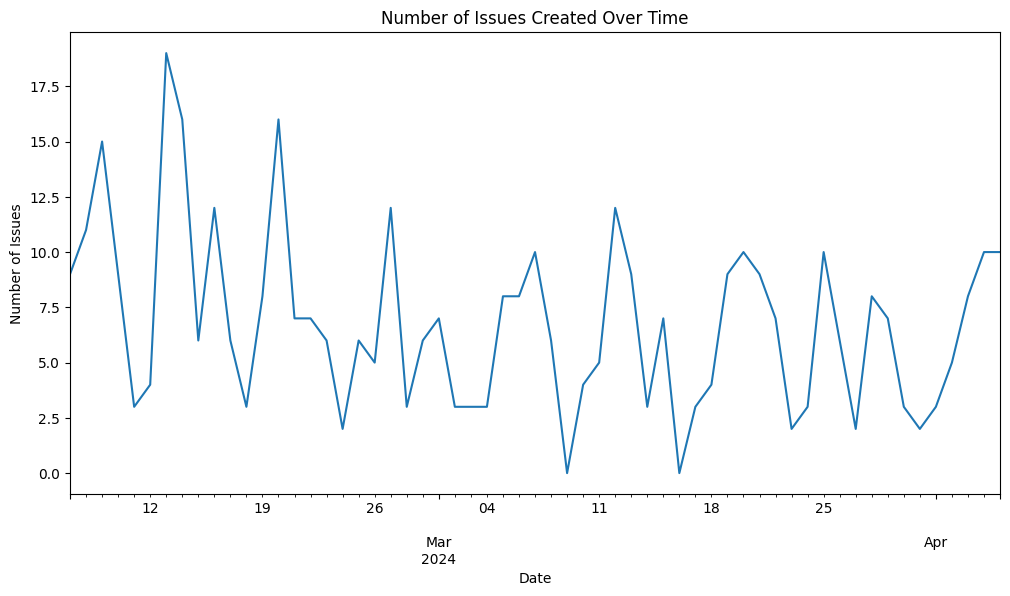

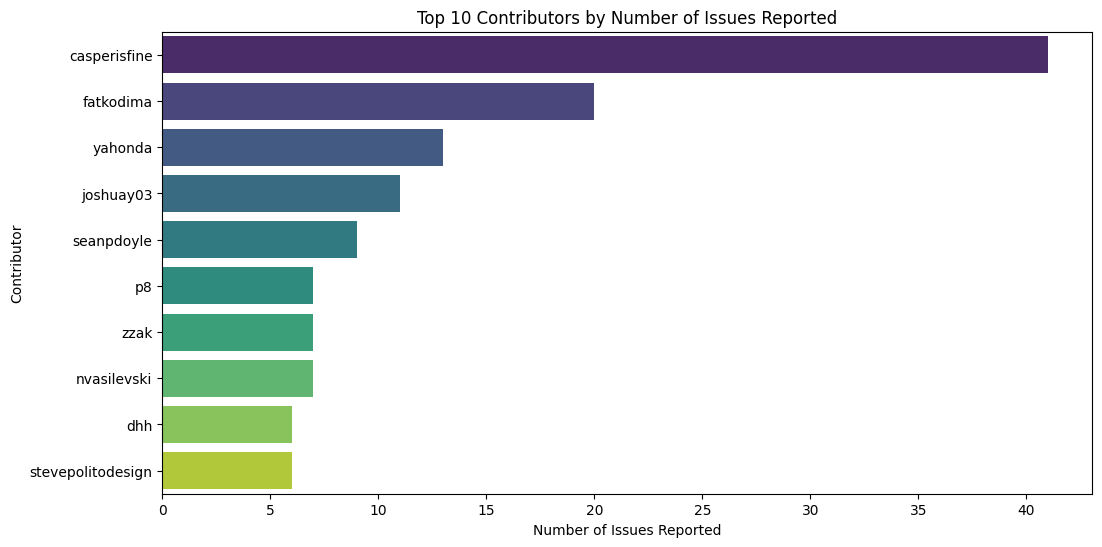

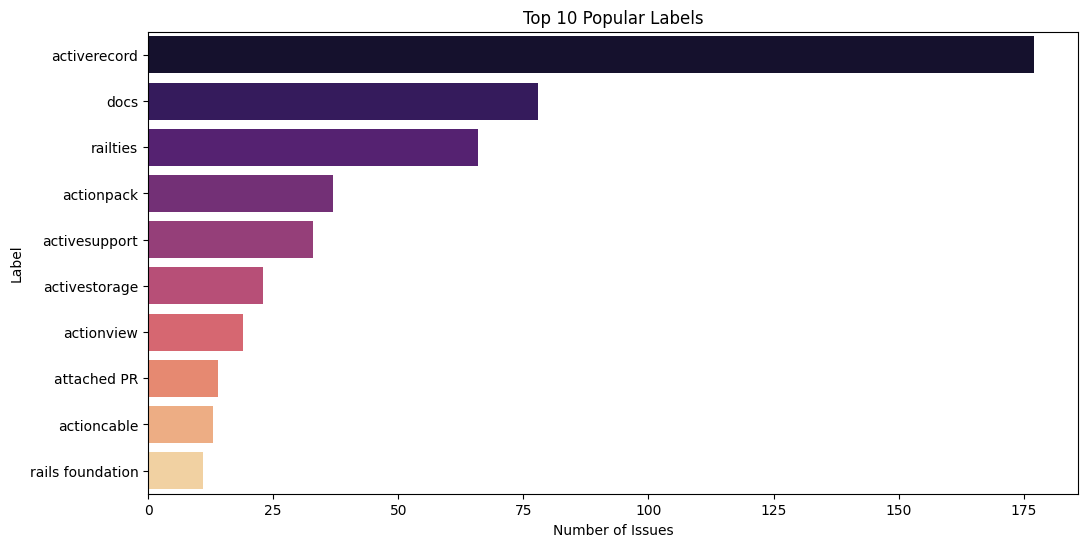

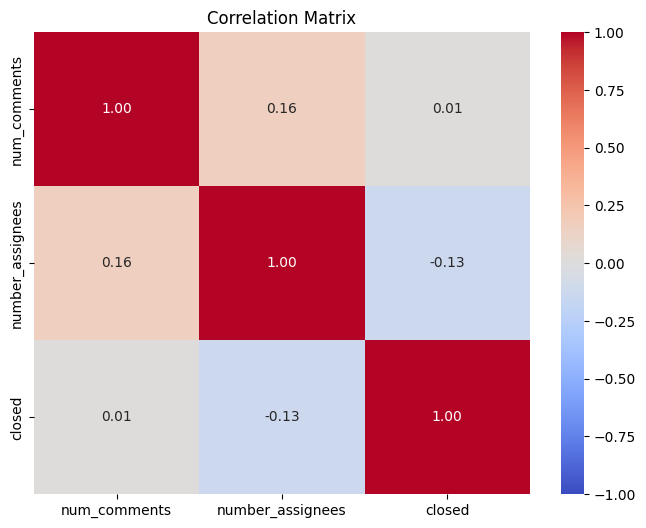

19

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot the number of issues created every day
plt.figure(figsize=(12, 6))
issues_df.set_index('created_at').resample('D').size().plot()
plt.title('Number of Issues Created Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Issues')
plt.show()

# Contributor Analysis
top_contributors = issues_df['author'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_contributors.values, y=top_contributors.index, palette='viridis', hue=top_contributors.index, legend=False)
plt.title('Top 10 Contributors by Number of Issues Reported')
plt.xlabel('Number of Issues Reported')
plt.ylabel('Contributor')
plt.show()

# Label Popularity Analysis
labels = issues_df['labels'].explode().value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=labels.values, y=labels.index, palette='magma', hue=labels.index, legend=False)
sns.barplot(x=labels.values, y=labels.index, palette='magma', hue=labels.index, legend=False)
plt.title('Top 10 Popular Labels')
plt.xlabel('Number of Issues')
plt.ylabel('Label')
plt.show()

# Correlation Analysis between the number of comments, the number of assignees, and time to resolution
correlation = issues_df[['num_comments', 'number_assignees', 'closed']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

issues_df.set_index('created_at').resample('D').size().max()

## Issue Classification

1. **Data Preparation**:
   - Prepare the dataset for machine learning by tokenizing the issue title and description using the Huggingface transformer tokenizer.
   - Split the data into training and test sets.
2. **Model Selection and Training**:
   - Choose a suitable model from HuggingFace’s transformers library, that is capable of text classification, in our case we choose the `DistilBertForSequenceClassification` model.
   - Train the model on the training set using the issue title + description as inputs and labels as targets.
3. **Model Evaluation**:
   - Evaluate the model on the test set to assess its performance in classifying issues into different labels.
   - Use metrics such as accuracy, precision, recall, and F1 score to measure the model's performance.

In [ ]:
! pip install -U accelerate
! pip install -U transformers
! pip install datasets
! pip install evaluate
! pip install datasets

In [38]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import TrainingArguments, Trainer

sample_df = issues_df[['title', 'body', 'labels']].copy()

sample_df['text'] = sample_df['title'] + ' ' + sample_df['body']

# We have multiple labels for each issue
mlb = MultiLabelBinarizer()
sample_df['labels'] = mlb.fit_transform(sample_df['labels']).astype(np.float32).tolist()

# Split dataset into 80/20 for training/testing
issues_dataset = Dataset.from_pandas(sample_df)
issues_dataset = issues_dataset.train_test_split(test_size=0.2)

model_name = 'distilbert-base-uncased'

# Tokenizing dataset
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Loading the model and specifying the number of expected labels
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(mlb.classes_), ignore_mismatched_sizes=True)

def tokenize_function(data):
    # - Padding is a strategy for ensuring tensors are rectangular by adding a
    #   special padding token to shorter sentences
    # - Sometimes a sequence may be too long for a model to handle.
    #   In this case, you’ll need to truncate the sequence to a shorter length.
    return tokenizer(data["text"], return_tensors='pt', truncation=True, padding=True)
tokenized_datasets = issues_dataset.map(tokenize_function, batched=True)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='weighted')
    rec = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}


# Training hyperparameters
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=64,
    save_steps=500,
    weight_decay=0.01,
    save_total_limit=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    load_best_model_at_end=True
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

# Save the model
trainer.save_model("./github_issue_classifier")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.357056,0.975000,0.950625,0.975000,0.962658


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.357056,0.975000,0.950625,0.975000,0.962658
2,No log,0.235966,0.975000,0.950625,0.975000,0.962658


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Evaluate the model

In [39]:
eval = trainer.evaluate()

accuracy = eval["eval_accuracy"]
precision = eval["eval_precision"]
recall = eval["eval_recall"]
f1 = eval["eval_f1"]
loss = eval["eval_loss"]

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Validation Loss: {loss:.4f}")

Accuracy: 0.9750
Precision: 0.9506
Recall: 0.9750
F1-Score: 0.9627
Validation Loss: 0.2360


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Test the model

In [58]:
new_text = "Problem with database connection. Please fix ASAP!"

model = AutoModelForSequenceClassification.from_pretrained("./github_issue_classifier")

inputs = tokenizer(new_text, return_tensors="pt", truncation=True, padding=True)

outputs = model(**inputs)
predicted_class_id = outputs.logits.argmax().item()

print(f"Predicted label: {mlb.classes_[predicted_class_id]}")

Predicted label: MySQL
